<a href="https://colab.research.google.com/github/gauravshetty98/Gaurav-GIS-Repo/blob/main/map_ps0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug intake and its corelation with other factors like mental health

In this project I try to find a corelation if any exists between the intake of drugs and other factors like mental health.

I am making use of SAMHSA 2021 NSDUH: state specific tables for this project. It is a dataset which contains PDFs containing drug intake data along with mental health data for each state.

Dataset link: https://www.samhsa.gov/data/report/2021-nsduh-state-specific-tables

The code for data extraction from these PDFs is already present in the Github repository.

------------

### Importing Python Libraries

aok: cool; just also make maps per capita, ie divide drugs by population--ie CA and TX have many people so there will be lots of drugs because there are many people, but doesnt mean that there is more drug problem than elsewhere

In [1]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
#! pip install geopandas
!pip install mapclassify
import geopandas as gpd
import mapclassify
import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable

#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

## Mapping geographic map

Since we are using data specific to the states of USA, we will be plotting a USA shape file.

In the code below, we first download the zip file from the internet. We then extract the zip file and search for USA shape file. Once found, we assign it to a variable and plot it.

In [2]:
! wget -q -O States_shapefile.zip https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/States_shapefile.zip

zip_ref = zipfile.ZipFile('States_shapefile.zip', 'r');
zip_ref.extractall();
zip_ref.close() #just unzipping
usa_shp = gpd.read_file('States_shapefile.shp') #load the shapefile with gpd as njC

<Axes: >

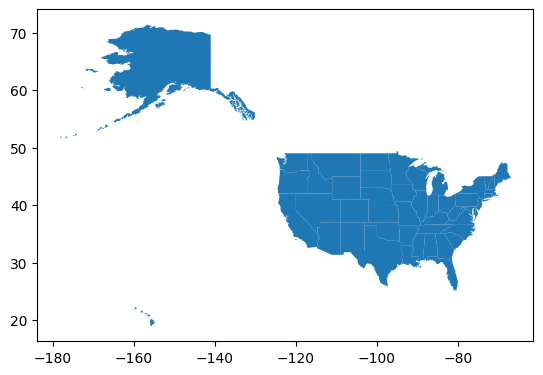

In [3]:
#make the map
usa_shp.plot()

## Other Information from the shape file

Here we check the different datatypes and columns present in the shape file

In [4]:
usa_shp.dtypes #with geopandas can do stuff like with pandas :)

FID              int64
Program         object
State_Code      object
State_Name      object
Flowing_St      object
FID_1            int64
geometry      geometry
dtype: object

In [5]:
usa_shp.columns

Index(['FID', 'Program', 'State_Code', 'State_Name', 'Flowing_St', 'FID_1',
       'geometry'],
      dtype='object')

<Axes: >

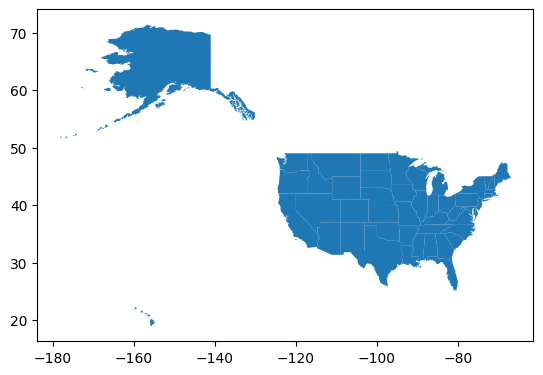

In [6]:
usa_shp.plot()

## Importing Drug Abuse Dataset

Here we import the drug use and mental health data extracted from NSDUH. We are importing this file from GitHub using `!wget`.

In [7]:
! wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/state_dataset.csv

dataset = pd.read_csv("state_dataset.csv")
dataset.head()

--2023-09-20 05:05:16--  https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/state_dataset.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/state_dataset.csv [following]
--2023-09-20 05:05:16--  https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/state_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168993 (165K) [text/plain]
Saving to: ‘state_dataset.csv’

state_dataset.csv   100%[===================>] 165.03K  --.-KB/s    in 0.03s   

2023-09-20 05:05:16 (4.87 MB/s) - ‘state_dataset.csv’ saved [168993/168993]



,index,Measure,12+,12-17,18-25,26+,18+,states
0,1,ILLICIT DRUGS Illicit Drug Use in the Past Mon...,403,17,98,288,386,Alabama
1,2,Marijuana Use in the Past Year,537,30,152,355,507,Alabama
2,3,Marijuana Use in the Past Month,315,16,90,209,299,Alabama
3,4,Perceptions of Great Risk from Smoking Marijua...,"1,128",105,83,940,"1,023",Alabama
4,6,First Use of Marijuana in the Past Year among ...,40,15,20,6,25,Alabama


### Making both DataFrames inline with each other

To make the merging easy, we change the state names to upper case and remove any spaces present in them.

We also change the Column name so that both dataframes have the same column names for states.

We also change the value for "District Of Columbia" so that both dataframes are inline with each other

In [8]:
dataset['states'] = dataset['states'].str.upper()
print(dataset.loc[1,'states'])

ALABAMA


In [9]:
usa_shp['State_Name'] = usa_shp['State_Name'].str.replace(' ', '')
print(usa_shp['State_Name'])

0                ALABAMA
1                 ALASKA
2                ARIZONA
3               ARKANSAS
4             CALIFORNIA
5               COLORADO
6            CONNECTICUT
7               DELAWARE
8     DISTRICTOFCOLUMBIA
9                FLORIDA
10               GEORGIA
11                HAWAII
12                 IDAHO
13              ILLINOIS
14               INDIANA
15                  IOWA
16                KANSAS
17              KENTUCKY
18             LOUISIANA
19                 MAINE
20              MARYLAND
21         MASSACHUSETTS
22              MICHIGAN
23             MINNESOTA
24           MISSISSIPPI
25              MISSOURI
26               MONTANA
27              NEBRASKA
28                NEVADA
29          NEWHAMPSHIRE
30             NEWJERSEY
31             NEWMEXICO
32               NEWYORK
33         NORTHCAROLINA
34           NORTHDAKOTA
35                  OHIO
36              OKLAHOMA
37                OREGON
38          PENNSYLVANIA
39           RHODEISLAND


In [10]:
dataset = dataset.rename(columns = {'states':'State_Name'})
dataset['State_Name'] = dataset['State_Name'].replace('DISTRICTOFCOL','DISTRICTOFCOLUMBIA')
dataset.columns

Index(['index', 'Measure', '12+', '12-17', '18-25', '26+', '18+',
       'State_Name'],
      dtype='object')

### Merging both the datasets

We have created two different datasets which have the complete information using inner and outer join.

We are not using these datasets at the moment, these are only for knowledge purpose.

In [11]:
complete_df_outer = pd.merge(usa_shp, dataset, on = 'State_Name', how = 'outer', indicator = True)
complete_df_outer.to_csv("dataset_merged_outer.csv")

In [12]:
complete_df_inner = pd.merge(usa_shp, dataset, on = 'State_Name', how = 'inner', indicator = True)
complete_df_inner.to_csv("dataset_merged_inner.csv")

## Mapping a geopanda plot of Illicit Drug Usage in USA

We start of with creating a dataframe which contains quantitative data about the amount of illicit drugs being consumed in USA.

In [13]:
illicit_drug_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "ILLICIT DRUGS Illicit Drug Use in the Past Month1,2":
    illicit_drug_df.loc[len(illicit_drug_df.index)] = dataset.loc[i,:]
print(illicit_drug_df.head())

  index                                            Measure    12+ 12-17  \
0     1  ILLICIT DRUGS Illicit Drug Use in the Past Mon...    403    17   
1    44  ILLICIT DRUGS Illicit Drug Use in the Past Mon...    127     6   
2    87  ILLICIT DRUGS Illicit Drug Use in the Past Mon...  1,133    63   
3   130  ILLICIT DRUGS Illicit Drug Use in the Past Mon...    281    13   
4   173  ILLICIT DRUGS Illicit Drug Use in the Past Mon...  5,207   215   

   18-25    26+    18+  State_Name  
0     98    288    386     ALABAMA  
1     22     99    121      ALASKA  
2    306    764  1,070     ARIZONA  
3     62    206    268    ARKANSAS  
4  1,123  3,869  4,993  CALIFORNIA  


In [14]:
print(illicit_drug_df.shape)

(56, 8)


Here we merge the new dataframe with the geopanda dataframe usa_shp

In [15]:
drug_map = pd.merge(usa_shp, illicit_drug_df, on = 'State_Name', how = 'inner', indicator = False)

During reading the CSV file some columns were read as strings. We cant plot properly with string values. Here we convert these strings to integer datatype using `to_numeric()` function

In [16]:
drug_map['12+'] = drug_map['12+'].str.replace(",","")
drug_map['12+'] = pd.to_numeric(drug_map['12+'])
type(drug_map.loc[2,'12+'])

numpy.int64

We have created a plot of State wise usage of Illicit Drugs.

All numbers are in thousands

<Axes: >

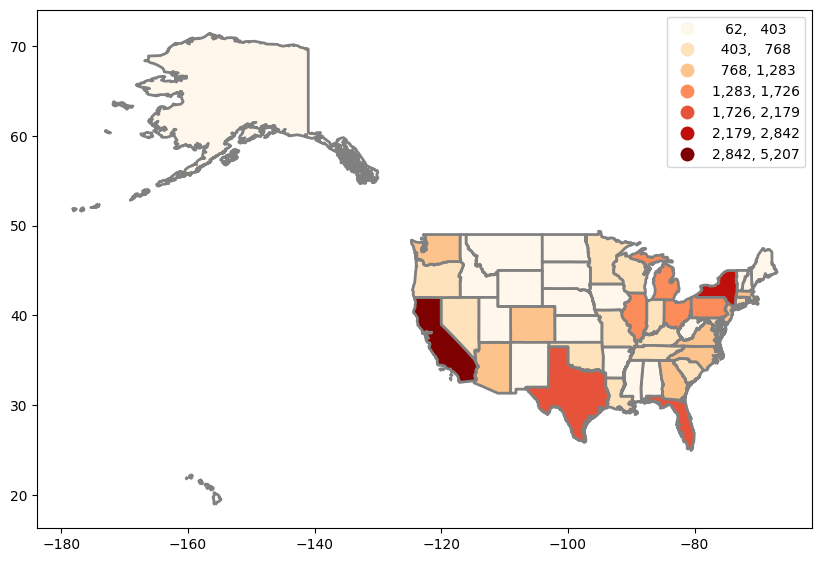

In [17]:
drug_map.plot(figsize=(10,12),column='12+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=2,legend_kwds= {"fmt": "{:,.0f}"})

## Mapping Alcohol use in USA

We follow the same steps and try to produce a heatmap for Alcohol use in USA

In [18]:
alcohol_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "ALCOHOL Alcohol Use in the Past Month":
    alcohol_df.loc[len(alcohol_df.index)] = dataset.loc[i,:]
print(alcohol_df.head())

  index                                Measure     12+ 12-17  18-25     26+  \
0    16  ALCOHOL Alcohol Use in the Past Month   1,636    24    202   1,411   
1    59  ALCOHOL Alcohol Use in the Past Month     293     4     33     256   
2   102  ALCOHOL Alcohol Use in the Past Month   2,797    41    398   2,357   
3   145  ALCOHOL Alcohol Use in the Past Month     982    16    141     825   
4   188  ALCOHOL Alcohol Use in the Past Month  15,040   196  1,769  13,075   

      18+  State_Name  
0   1,613     ALABAMA  
1     289      ALASKA  
2   2,756     ARIZONA  
3     966    ARKANSAS  
4  14,844  CALIFORNIA  


In [19]:
alcohol_df['12+'] = alcohol_df['12+'].str.replace(",","")
alcohol_df['12+'] = pd.to_numeric(alcohol_df['12+'])
print("Datatype: ", type(alcohol_df.loc[2,'12+']))
alcohol_map = pd.merge(usa_shp, alcohol_df, on = 'State_Name', how = 'inner', indicator = False)

Datatype:  <class 'numpy.int64'>


<Axes: >

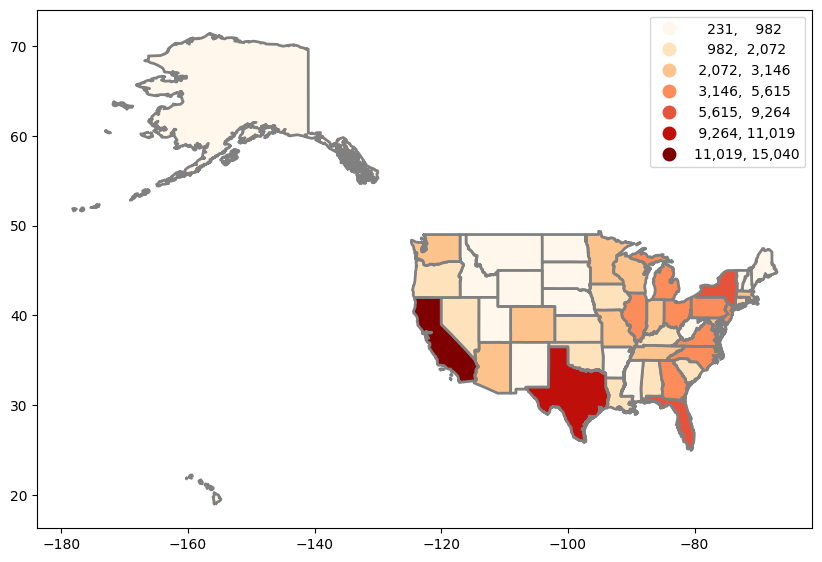

In [20]:
alcohol_map.plot(figsize=(10,12),column='12+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=2,legend_kwds= {"fmt": "{:,.0f}"})

## Mental health issues reported in USA

We follow the same steps to create a heatmap for the mental health issues being reported in USA

In [21]:
mental_health_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "MENTAL HEALTH MEASURES IN THE PAST YEAR Any Mental Illness4,10":
    mental_health_df.loc[len(mental_health_df.index)] = dataset.loc[i,:]
print(mental_health_df.head())

  index                                            Measure 12+ 12-17  18-25  \
0    27  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0    150   
1    70  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0     26   
2   113  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0    244   
3   156  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0    100   
4   199  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0  1,330   

     26+    18+  State_Name  
0    717    867     ALABAMA  
1    112    138      ALASKA  
2    970  1,214     ARIZONA  
3    424    524    ARKANSAS  
4  5,516  6,846  CALIFORNIA  


In [22]:
mental_health_df['18+'] = mental_health_df['18+'].str.replace(",","")
mental_health_df['18+'] = pd.to_numeric(mental_health_df['18+'])
print("Datatype: ", type(mental_health_df.loc[2,'18+']))
mental_health_map = pd.merge(usa_shp, mental_health_df, on = 'State_Name', how = 'inner', indicator = False)

Datatype:  <class 'numpy.int64'>


<Axes: >

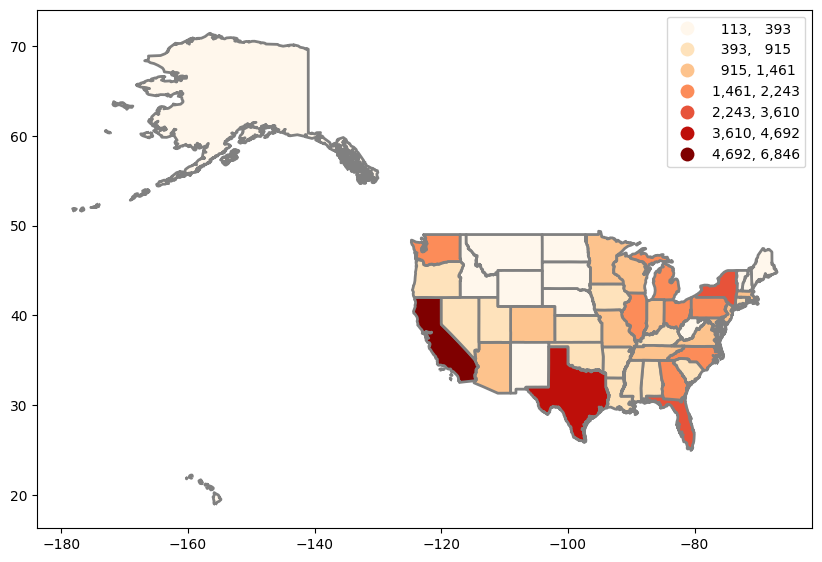

In [23]:
mental_health_map.plot(figsize=(10,12),column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=2,legend_kwds= {"fmt": "{:,.0f}"})

## Introducing the population element

We have mapped the amount of drugs being consumed in each state but we havent taken into consideration the population of each state. If we do not take the population of each state into consideration, these statistics can be a bit misleading.  

We start of importing the CENSUS estimates for population of each state for the age of 18 and above.

In [24]:
!wget -O population_data https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/SCPRC-EST2022-18%2BPOP.xlsx

--2023-09-20 05:05:39--  https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/SCPRC-EST2022-18%2BPOP.xlsx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/SCPRC-EST2022-18%2BPOP.xlsx [following]
--2023-09-20 05:05:40--  https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/SCPRC-EST2022-18%2BPOP.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14025 (14K) [application/octet-stream]
Saving to: ‘population_data’

population_data     100%[===================>]  13.70K  --.-KB/s    in 0.001s  

2023-09-20 05:05:40 (23.0 MB/s) - ‘population

In [25]:
population =  pd.read_excel('population_data')
population.head(10)

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Estimates of the Total Resident Population and...,NaN,NaN,NaN
1,Geographic Area,Total Resident\nPopulation,Resident Population Age 18\n Years and Older,NaN
2,NaN,NaN,Number,Percent
3,United States,333287557,260836730,78.3
4,Northeast,57040406,45544589,79.8
5,Midwest,68787595,53626659,78
6,South,128716192,100098310,77.8
7,West,78743364,61567172,78.2
8,.Alabama,5074296,3962734,78.1
9,.Alaska,733583,557060,75.9


In [26]:
population.iloc[:,0] = population.iloc[:,0].str.upper()
population.iloc[:,0] = population.iloc[:,0].str.replace(".","")
population = population.iloc[8:59,0:3]
population.head(10)

<ipython-input-26-61cd5d5f3361>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  population.iloc[:,0] = population.iloc[:,0].str.replace(".","")


,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2
8,ALABAMA,5074296,3962734
9,ALASKA,733583,557060
10,ARIZONA,7359197,5770187
11,ARKANSAS,3045637,2348518
12,CALIFORNIA,39029342,30523315
13,COLORADO,5839926,4624351
14,CONNECTICUT,3626205,2895175
15,DELAWARE,1018396,810269
16,DISTRICT OF COLUMBIA,671803,547328
17,FLORIDA,22244823,17948469


In [27]:
population.tail(5)

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2
54,VIRGINIA,8683619,6816709
55,WASHINGTON,7785786,6139213
56,WEST VIRGINIA,1775156,1423234
57,WISCONSIN,5892539,4646910
58,WYOMING,581381,451267


In [28]:
population.columns

Index(['table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)',
       'Unnamed: 1', 'Unnamed: 2'],
      dtype='object')

In [29]:
population = population.rename(columns = {'table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)':'State_Name', 'Unnamed: 1':'Total Population', 'Unnamed: 2':'Above 18'})
population.columns

Index(['State_Name', 'Total Population', 'Above 18'], dtype='object')

In [35]:
usa_shp_pop_outer = pd.merge(usa_shp, population, on = 'State_Name', how = 'outer', indicator = 'exists')
usa_shp_pop_outer.to_csv("dataset_merged_outer_with_population.csv")

usa_shp_pop_inner = pd.merge(usa_shp, population, on = 'State_Name', how = 'inner', indicator = 'exists')
usa_shp_pop_inner.to_csv("usa_shp_inner_with_population.csv")

<Axes: >

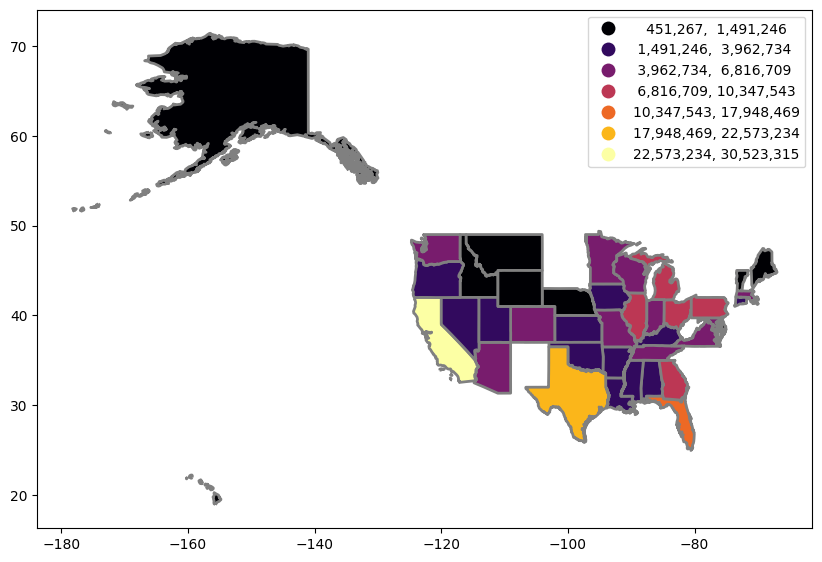

In [40]:
usa_shp_pop_inner.plot(figsize=(10,12),column='Above 18',legend=True,cmap='inferno',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=2,legend_kwds= {"fmt": "{:,.0f}"})